In [1]:
import os
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
sys.path.append('../')

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.utils.data import DataLoader, Subset
from data_utils import get_eval_data
from model.unet import get_unet
from utils import epoch_average
from monai.metrics import DiceMetric
from omegaconf import OmegaConf
from typing import Dict
from adapters import PCA_Adapter, PCAModuleWrapper

In [2]:
def eval_set(cfg, model, dataset):
    if cfg.run.data_key == 'prostate':
        dataloader = DataLoader(dataset, batch_size=cfg.unet.prostate.training.batch_size,
                                shuffle=False, drop_last=False)

        eval_metrics = {
            "Dice Score": DiceMetric(
                ignore_empty=True,
                include_background=True
            )
        }

        metrics = eval_pmri_set(
            model=model,
            dataloader=dataloader,
            eval_metrics=eval_metrics
        )
    else:
        raise ValueError(
            f'Invalid data key. No config for dataset named {cfg.run.data_key}'
        )
    return metrics

@torch.no_grad()
def eval_pmri_subdice(model, dataset, tmp_dists, th_val):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False)
    model.eval()
    dice_scores = []
    dm = DiceMetric(ignore_empty=True, include_background=True)
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target']
        out = model(input_.cuda()).detach().cpu()
        out = torch.argmax(out, dim=1).unsqueeze(1)
        batch_dices = dm(out, target).detach().cpu()
        dice_scores.append(batch_dices)
    dice_scores = torch.cat(dice_scores, dim=0)
    iid_idx = (tmp_dists <= th_val).nonzero().squeeze()
    ood_idx = (tmp_dists >  th_val).nonzero().squeeze()
    iid_dice = dice_scores[iid_idx].mean().item()
    ood_dice = dice_scores[ood_idx].mean().item()
    return iid_dice, ood_dice

@torch.no_grad()
def eval_pmri_set(model, dataloader, eval_metrics):
    model.eval()
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    batch_sizes = []
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target']
        batch_sizes.append(input_.shape[0])
        out = model(input_.cuda()).detach().cpu()
        out = torch.argmax(out, dim=1).unsqueeze(1)
        for key, metric in eval_metrics.items():
            computed_metric = metric(out, target).detach().mean().cpu()
            epoch_metrics[key].append(computed_metric)

    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
    return epoch_metrics

def get_df_from_dict(cfg, metrics: Dict):
    # convert dict into seaborn-friendly pandas format
    df = pd.DataFrame.from_dict(metrics).T
    df['Domain'] = df.index
    df.reset_index(drop=True, inplace=True)
    df = pd.melt(
        df, 
        id_vars=['Domain'],
        value_vars=df.columns.drop('Domain')
    )
    # add additional identifiers from config
    # df['Iteration'] = cfg.run.iteration
    # df['Model'] = cfg.unet[cfg.run.data_key].pre
    # df['Data'] = cfg.run.data_key
    return df

def plot_batch(dataset, model, num_images=9, title=None):
    assert 0 < num_images <= 9
    idx = random.sample(range(len(dataset)), num_images)
    data = dataset[idx]
    with torch.no_grad():
        model.eval()
        pred = model(data['input'].cuda()).detach().cpu()
        pred = torch.argmax(pred, dim=1)

    fig, axes = plt.subplots(num_images, 4, figsize=(6, num_images*2))

    # Iterate over the images and plot them in the grid
    for i in range(num_images):
        if i == 0:
            axes[i][0].set_title('Image')
            axes[i][1].set_title('Target')
            axes[i][2].set_title('Predicted')
            axes[i][3].set_title('Diff')
        axes[i, 0].imshow(data['input'][i][0, ...], cmap='gray')
        axes[i, 1].imshow(data['target'][i][0, ...], cmap='gray')
        axes[i, 2].imshow(pred[i], cmap='gray')
        diff = torch.abs(pred[i] - data['target'][i][0, ...])
        axes[i, 3].imshow(diff, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 3].axis('off')

    if title is not None:
        fig.suptitle(title, fontsize=10)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [3]:
# Set mode
MODE = 'eval'
LOG = False
ITERATION = 0
DATA_KEY = 'prostate'
LOAD_ONLY_PRESENT = True
VALIDATION = True
EXTRA_DESCRIPTION = '_base'
N_DIMS = [2, 4, 8, 16, 32, 64]

cfg = OmegaConf.load('../configs/conf.yaml')
OmegaConf.update(cfg, 'run.iteration', ITERATION)
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)

unet_name = 'monai-64-4-4'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = None if unet_name == 'swinunetr' else int(args[1])
cfg.unet[DATA_KEY].training.load_only_present = LOAD_ONLY_PRESENT
cfg.unet[DATA_KEY].training.validation = VALIDATION
cfg.unet[DATA_KEY].training.batch_size = 32
cfg.wandb.project = f'{DATA_KEY}_{unet_name}_{ITERATION}{EXTRA_DESCRIPTION}'

if MODE == 'eval':
    # Set cfg.format to "numpy" for evaluation,
    # otherwise don't modify it or set to "torch" for training
    cfg.format = 'numpy'
    LOG = False

cfg.wandb.log = LOG

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

layer_names = ['model.0.conv',
               'model.1.submodule.0.conv',
               'model.1.submodule.1.submodule.0.conv',
               'model.1.submodule.1.submodule.1.submodule.0.conv']

Loading evaluation PMRI dataset for vendor siemens ...
Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


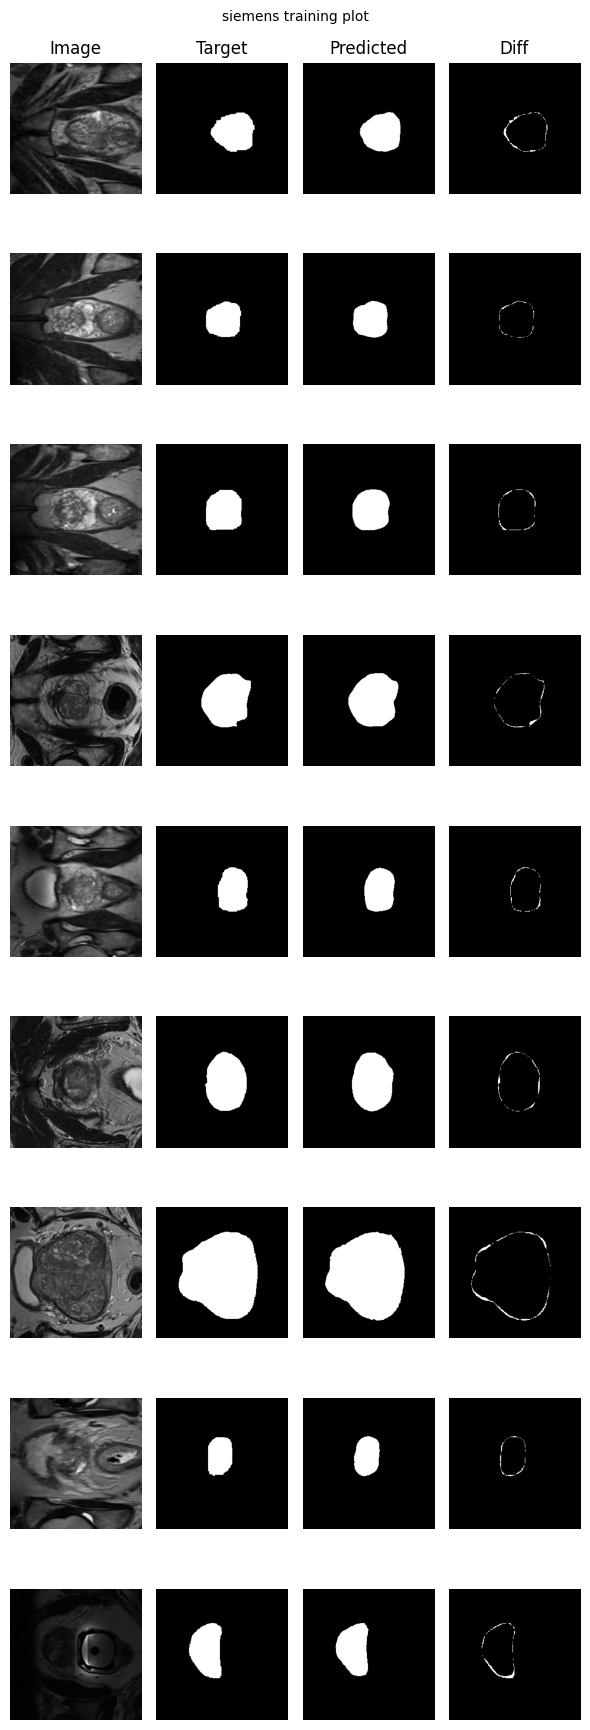

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


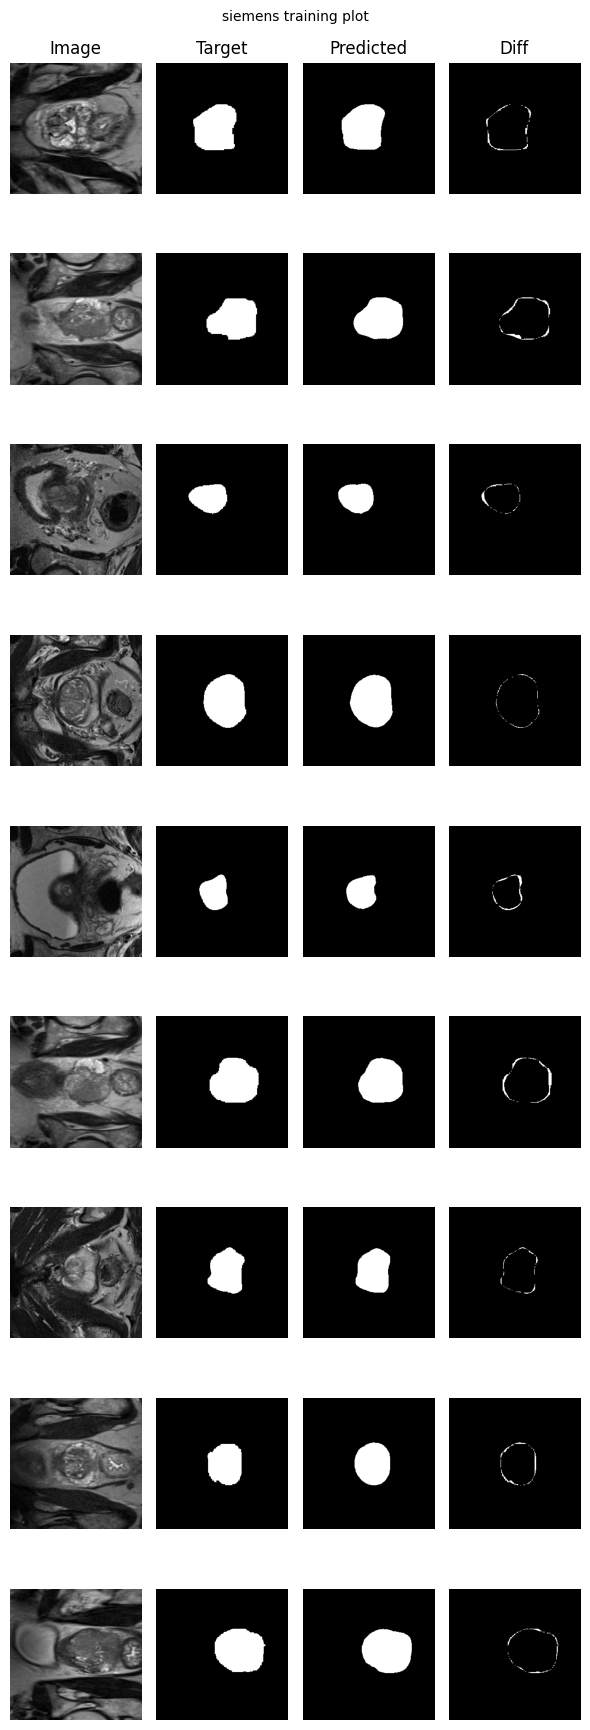

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


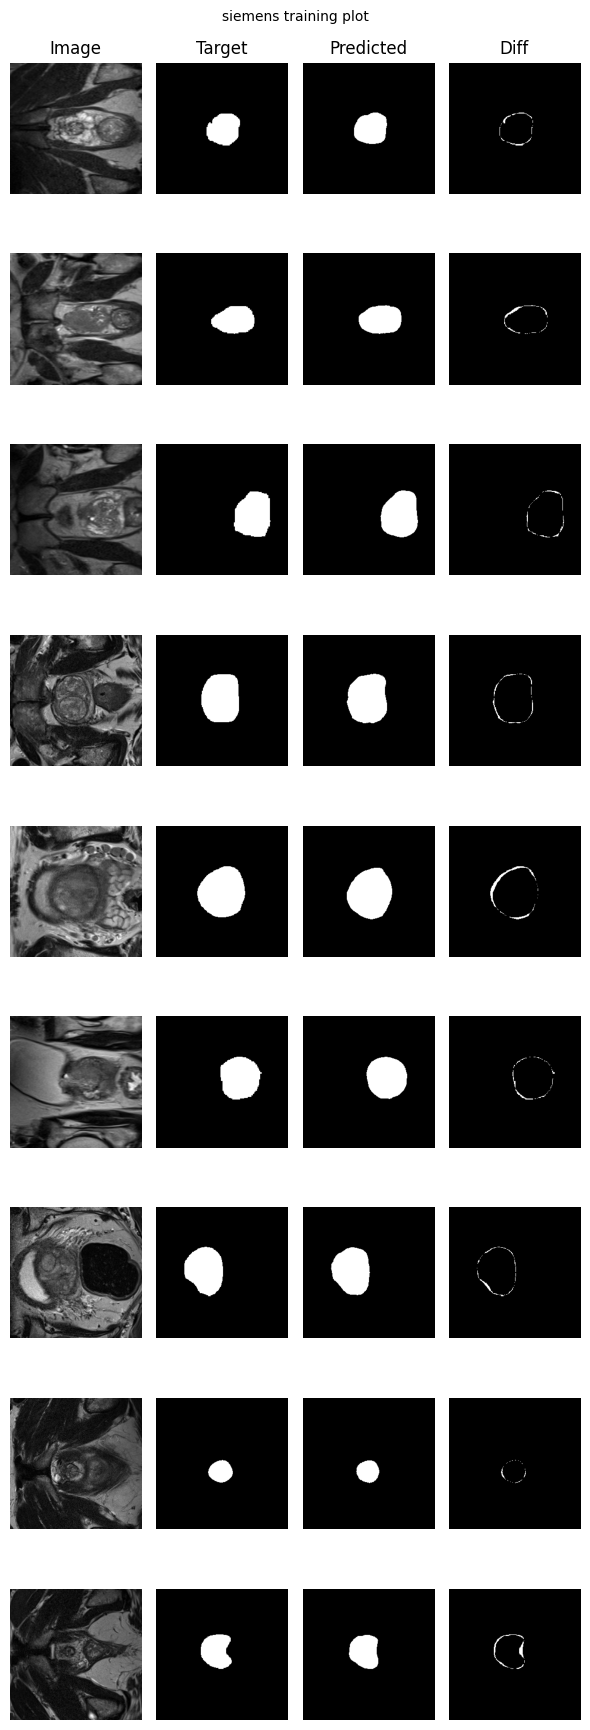

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


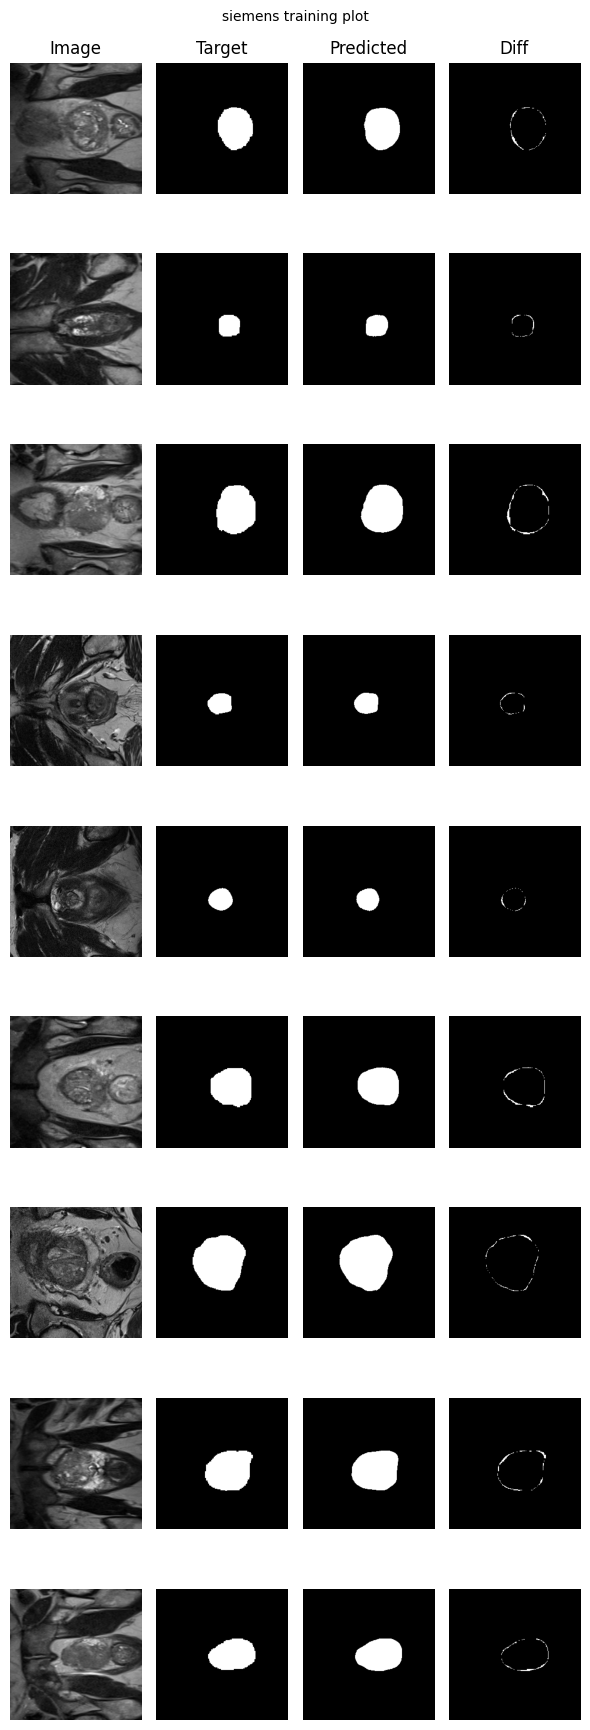

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


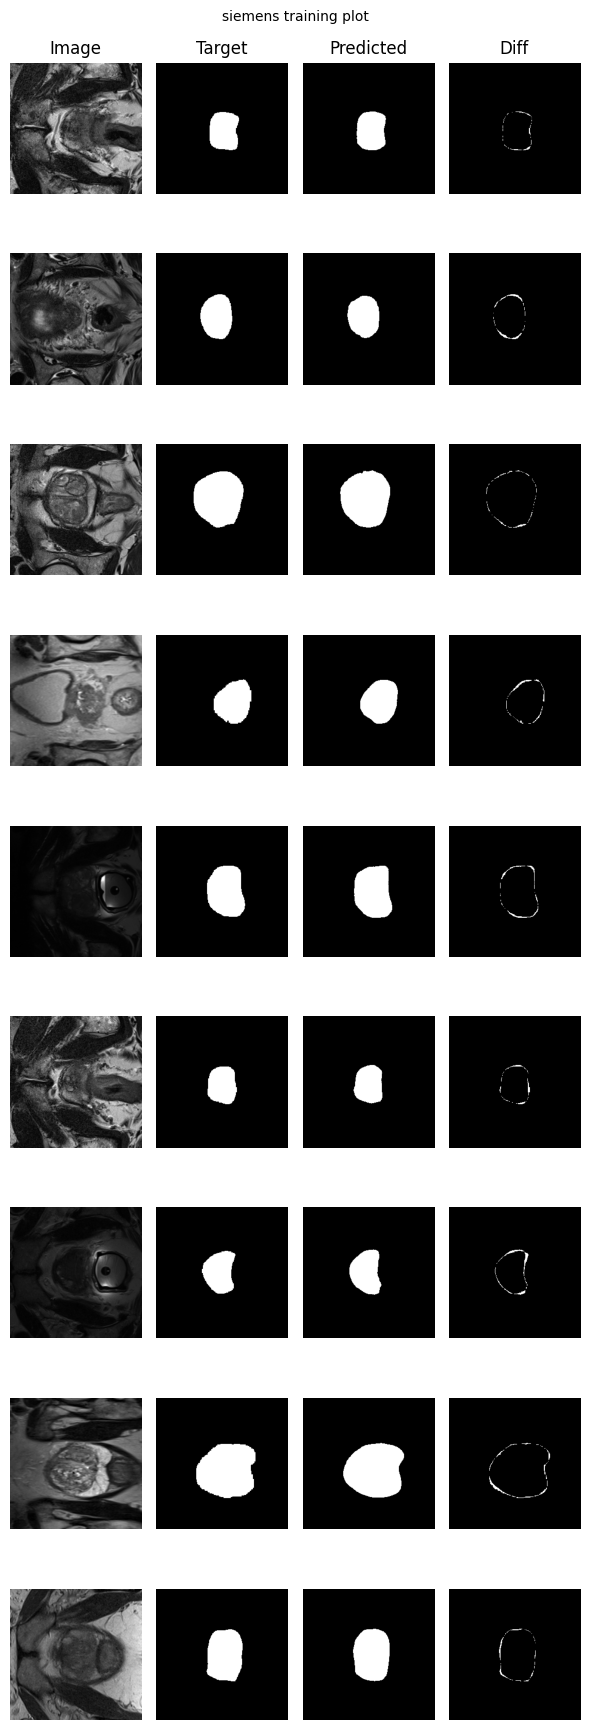

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


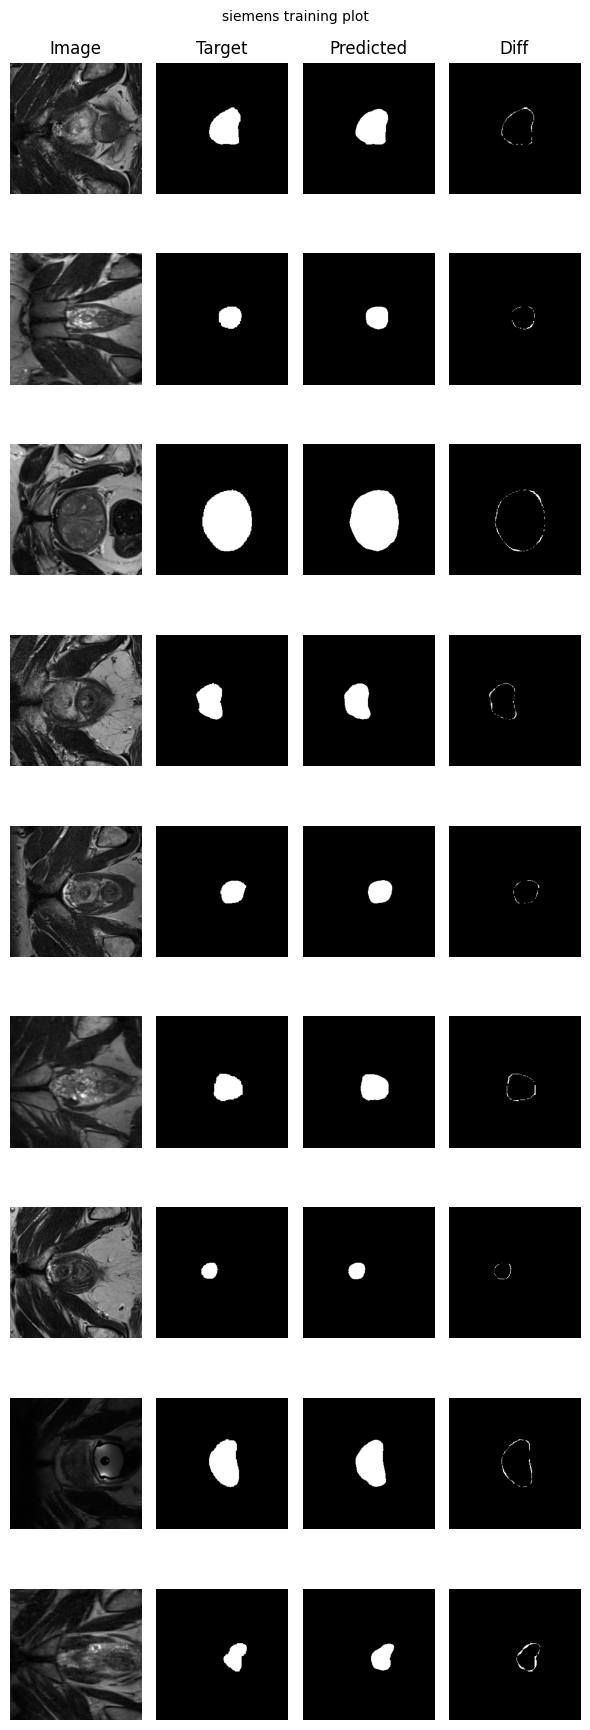

In [4]:
PLOT = True
MAHAL_DIST_PERCENTILE_CUT = 0.9
train_vendors = ['siemens']
metrics = {}
cut_values = {}
distribution_results = {}

for vendor in train_vendors:
    cfg.unet[DATA_KEY].training.subset = 'training'
    cfg.unet[DATA_KEY].training.vendor = vendor
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    for n_dims in N_DIMS:
        adapters = [PCA_Adapter(swivel, n_dims, cfg.unet[DATA_KEY].training.batch_size,
                                pre_fit=True, train_gaussian=False, compute_dist=True,
                                name=cfg.wandb.project) for swivel in layer_names]
        adapters = nn.ModuleList(adapters)
        unet, state_dict = get_unet(cfg, update_cfg_with_swivels=False, return_state_dict=True)
        unet_adapted = PCAModuleWrapper(model=unet, adapters=adapters)
        unet_adapted.hook_adapters()
        unet_adapted.to(device);
        metrics[n_dims] = metrics.get(n_dims, {})
        cut_values[n_dims] = cut_values.get(n_dims, {})
        distribution_results[n_dims] = distribution_results.get(n_dims, {})
        for key in data.keys():
            # print(f'Training dataset length of vendor {vendor}: {len(data[key])}')
            metrics[n_dims][f'{vendor}_train'] = eval_set(
                cfg=cfg,
                model=unet_adapted,
                dataset=data[key]
            )
        for adapter in unet_adapted.adapters:
            adapter.reduce_dims = False
            adapter.train_gaussian = False
            adapter.compute_dist = False
            

        for adapter in unet_adapted.adapters:
            tmp_dists = torch.cat(adapter.distances, dim=0).detach().cpu()
            th_val = torch.quantile(tmp_dists, MAHAL_DIST_PERCENTILE_CUT).item()
            cut_values[n_dims][f'mahal_th_{MAHAL_DIST_PERCENTILE_CUT}_{adapter.swivel}'] = th_val
            metrics[n_dims][f'{vendor}_train'][f'mahal_mean_{adapter.swivel}'] = tmp_dists.mean().item()
            ood = int(torch.sum(tmp_dists > th_val).item())
            iid = int(torch.sum(tmp_dists <= th_val).item())
            metrics[n_dims][f'{vendor}_train'][f'{adapter.swivel}_ood'] = ood
            metrics[n_dims][f'{vendor}_train'][f'{adapter.swivel}_iid'] = iid
            metrics[n_dims][f'{vendor}_train'][f'{adapter.swivel}_pct_iid'] = iid / (iid + ood)
            metrics[n_dims][f'{vendor}_train'][f'{adapter.swivel}_pct_ood'] = ood / (iid + ood)
            if adapter.swivel == layer_names[1]:
                iid_dice, ood_dice = eval_pmri_subdice(unet_adapted, data['eval'], tmp_dists, th_val)
                metrics[n_dims][f'{vendor}_train'][f'{adapter.swivel}_dice_iid'] = iid_dice
                metrics[n_dims][f'{vendor}_train'][f'{adapter.swivel}_dice_ood'] = ood_dice
    
    if PLOT: plot_batch(data[key], unet_adapted, title=f'{vendor} training plot')


Loading evaluation PMRI dataset for vendor siemens ...
Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


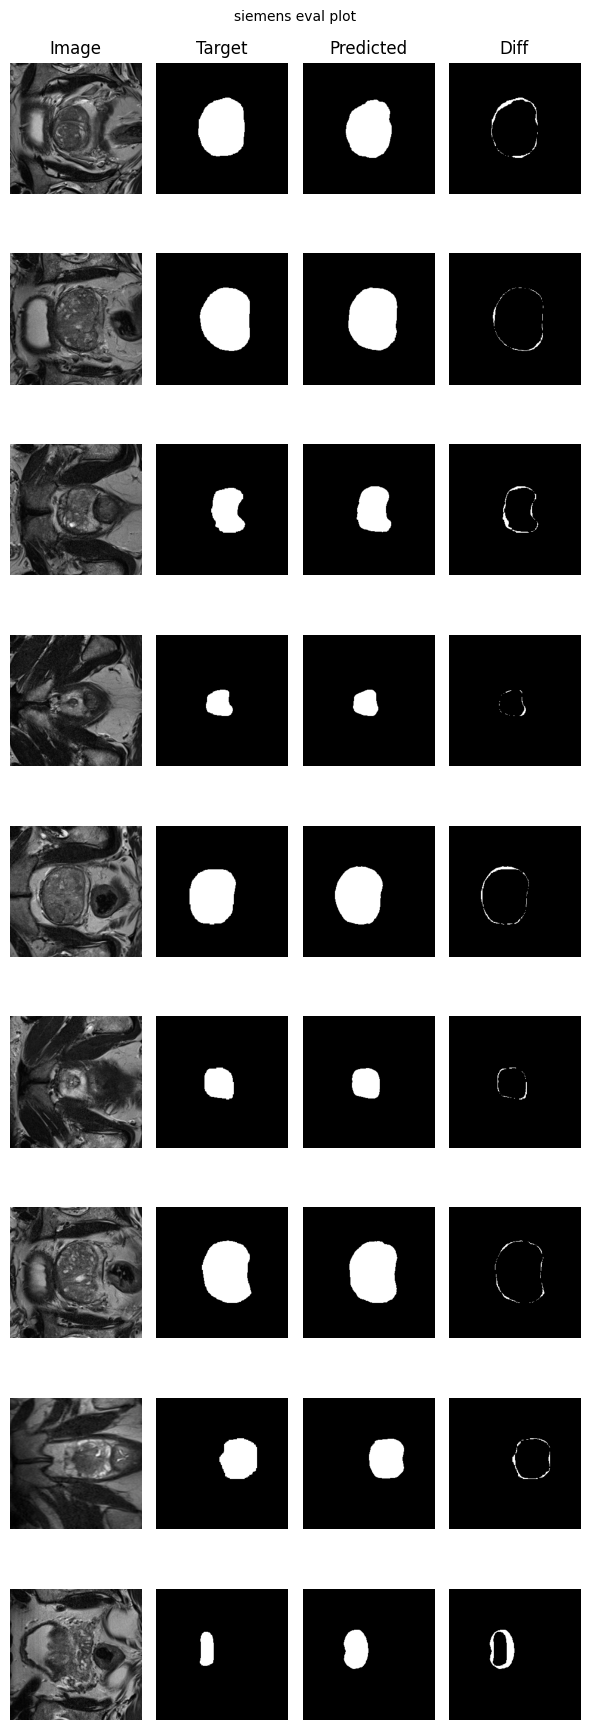

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


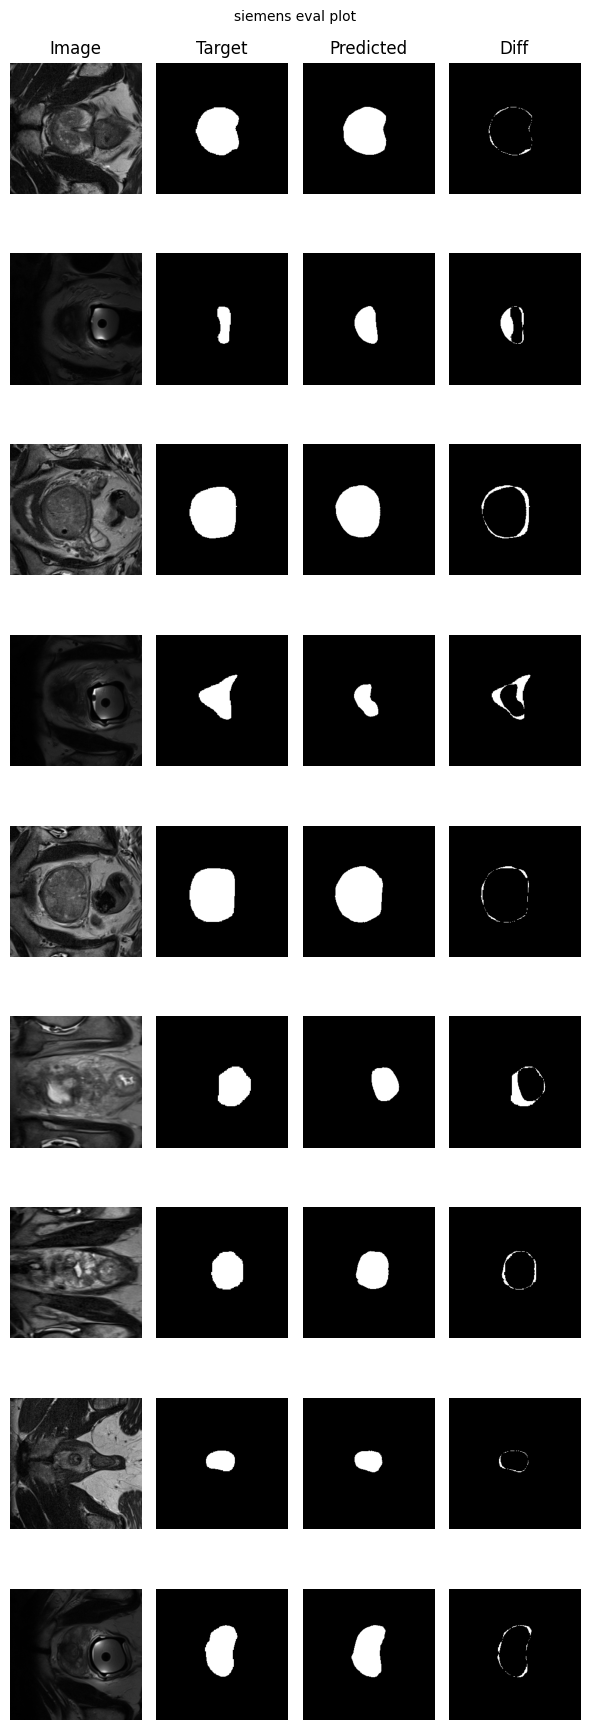

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


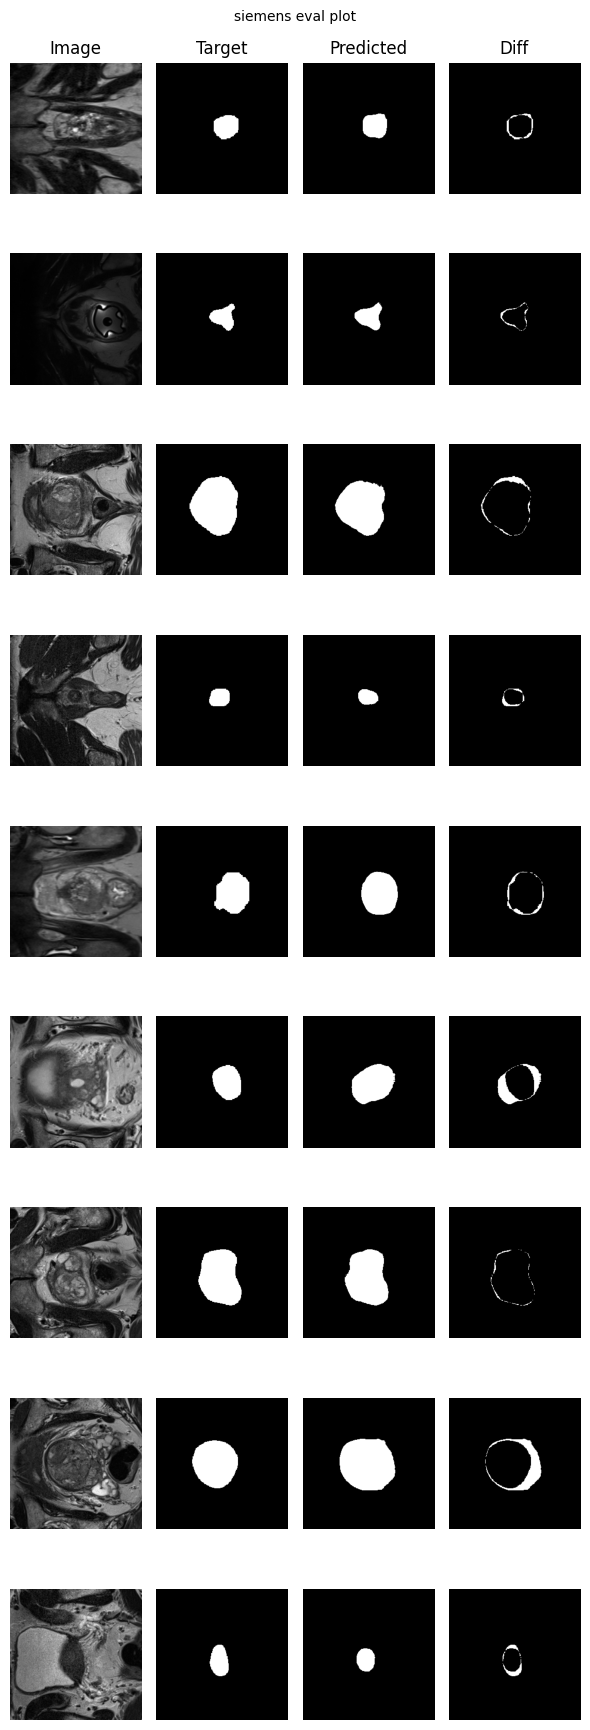

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


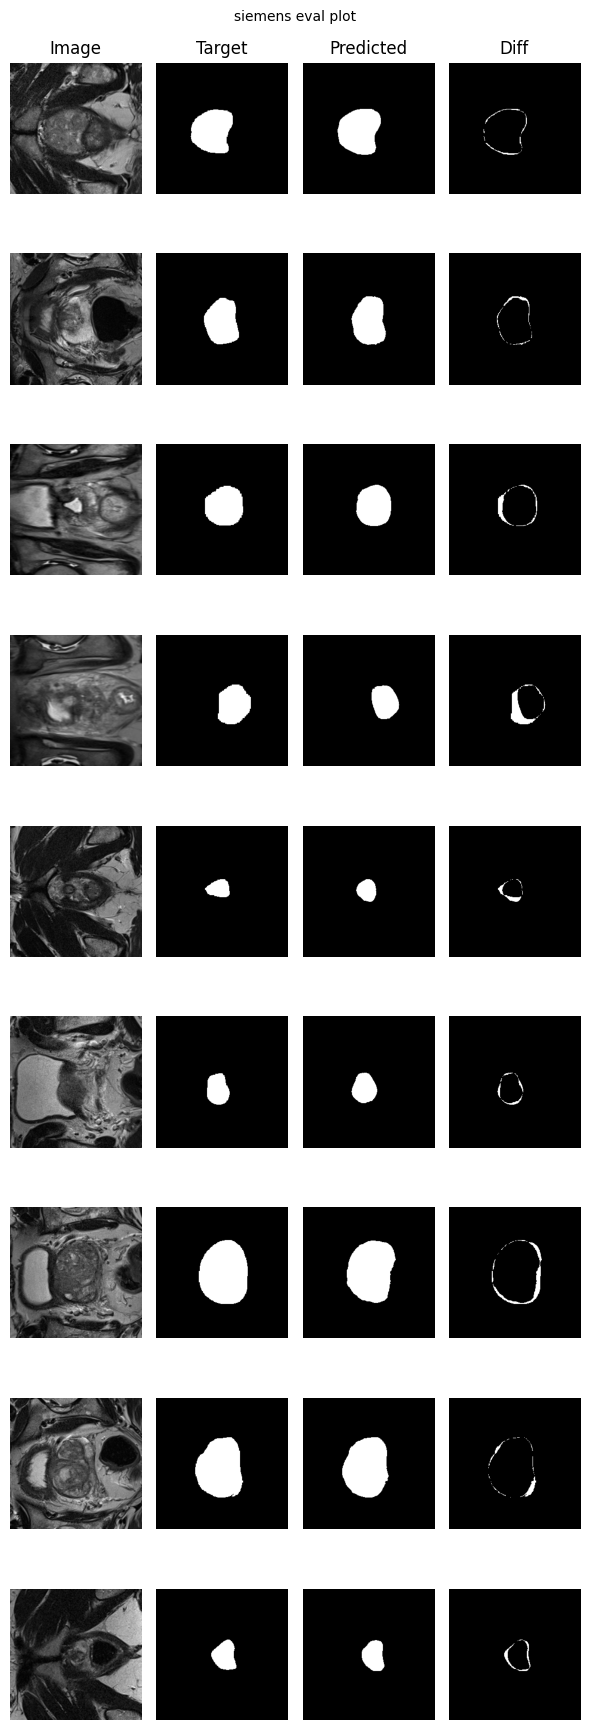

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


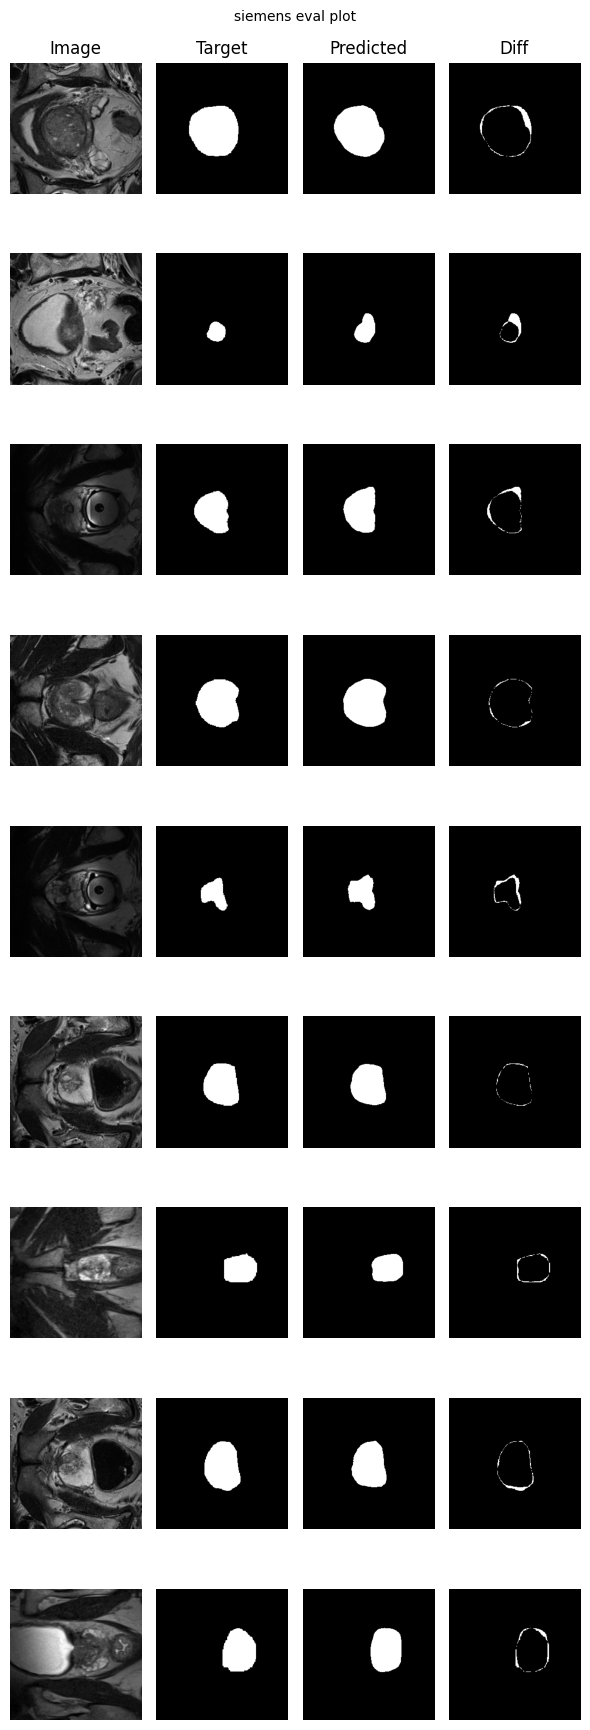

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


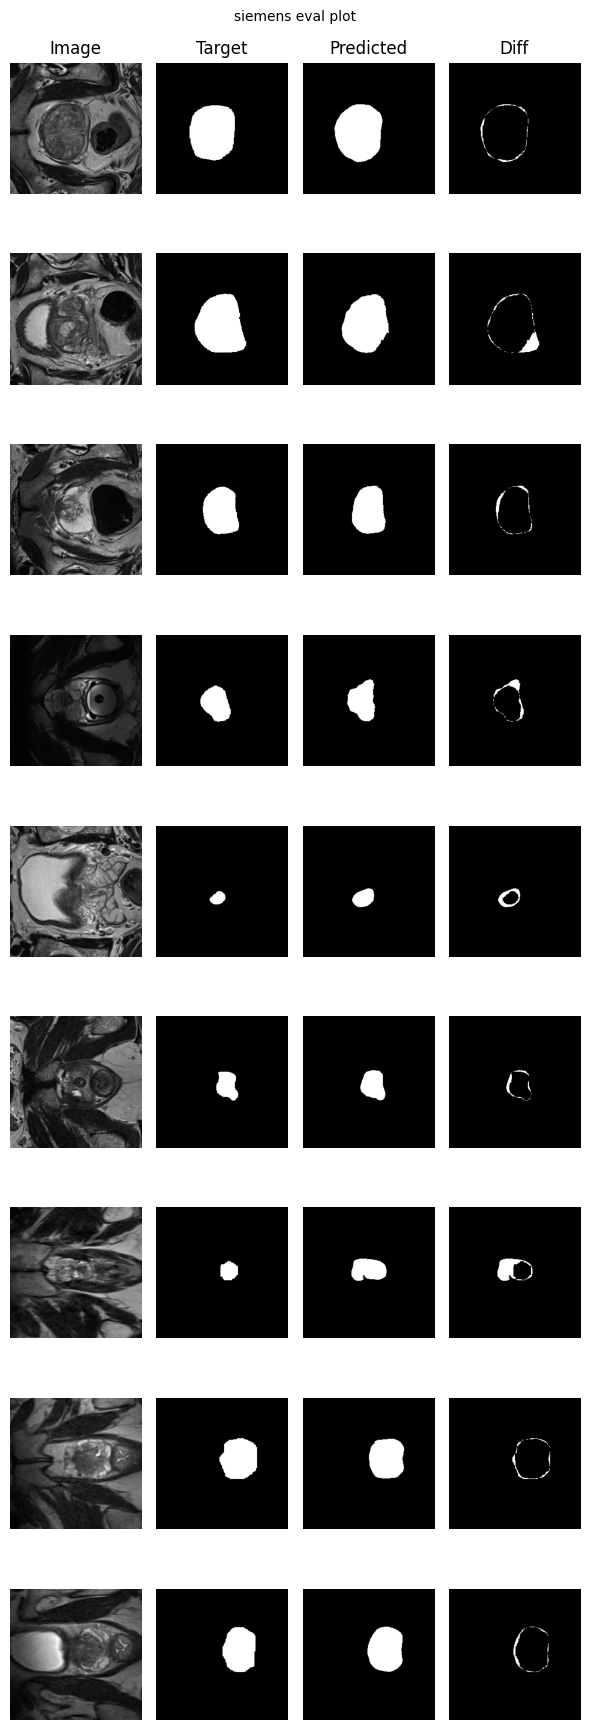

Loading evaluation PMRI dataset for vendor philips ...
Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


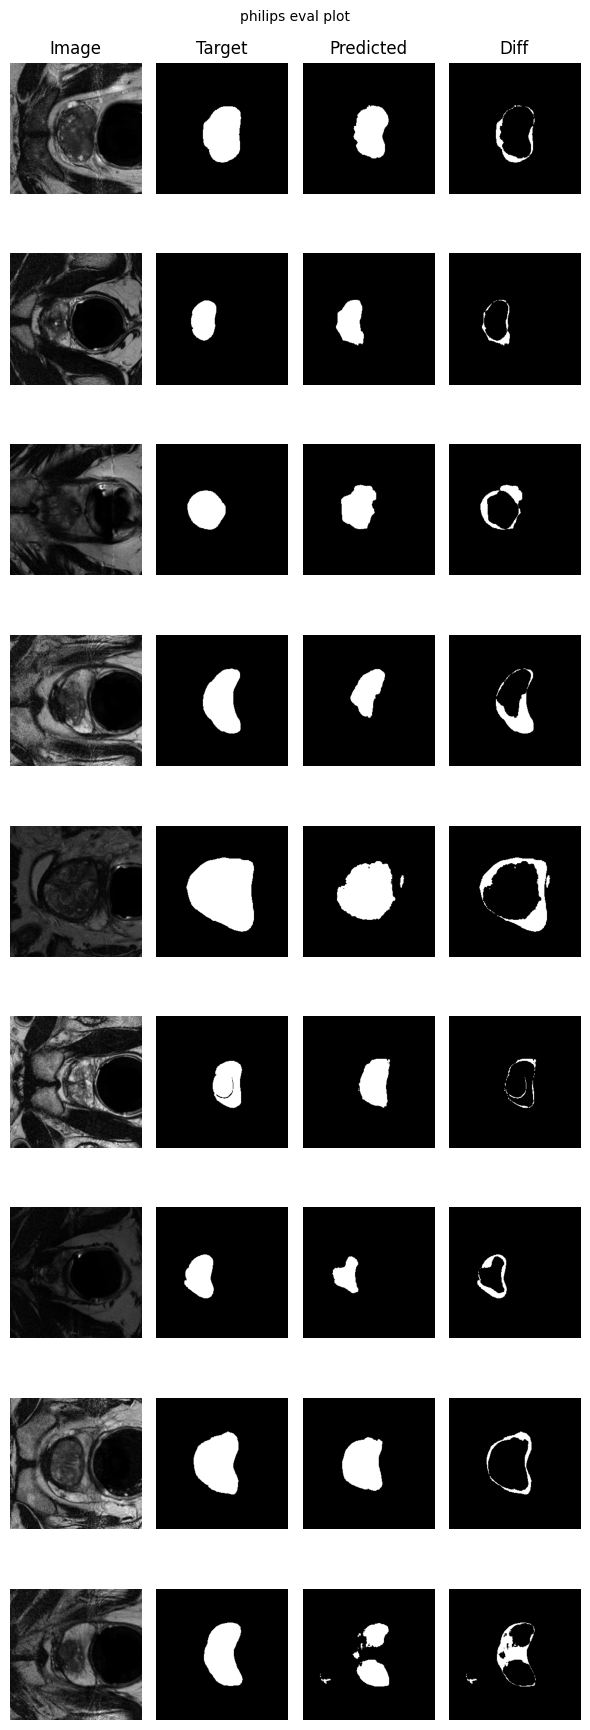

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


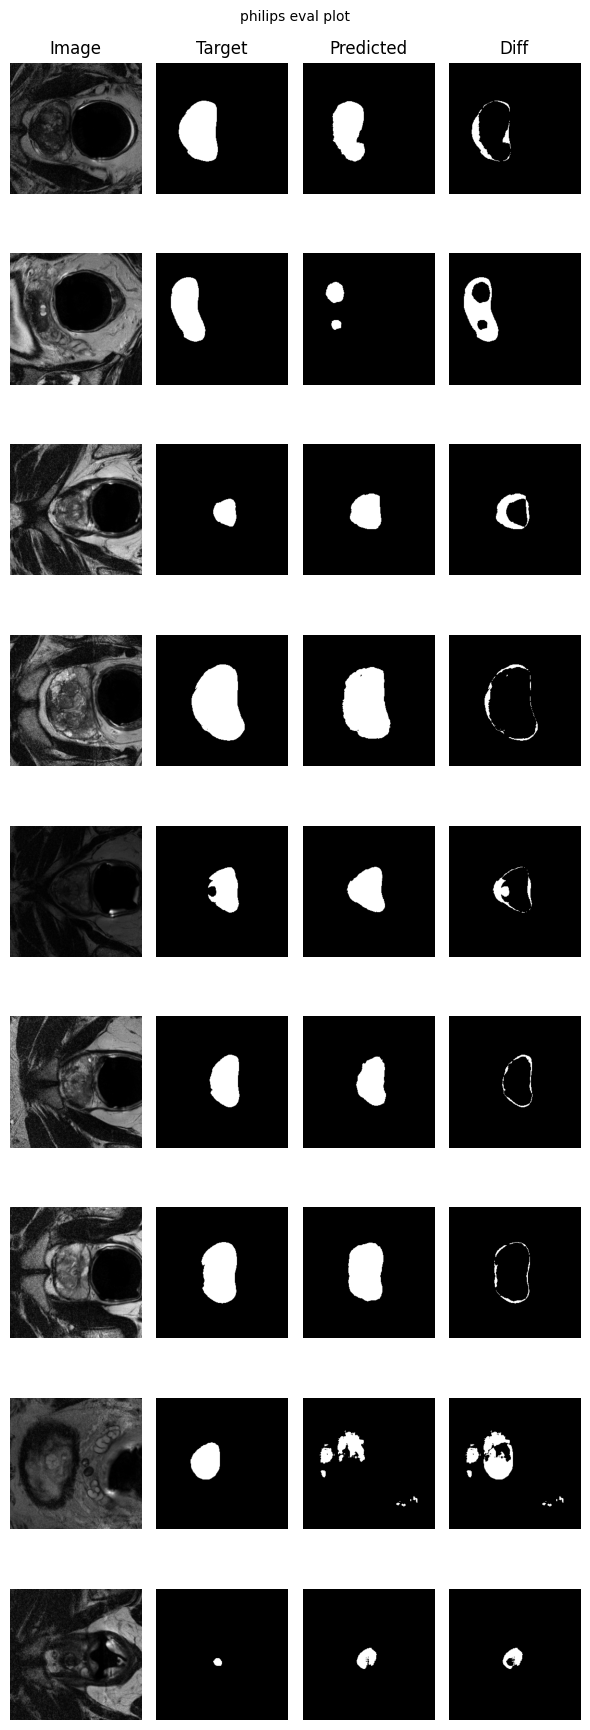

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


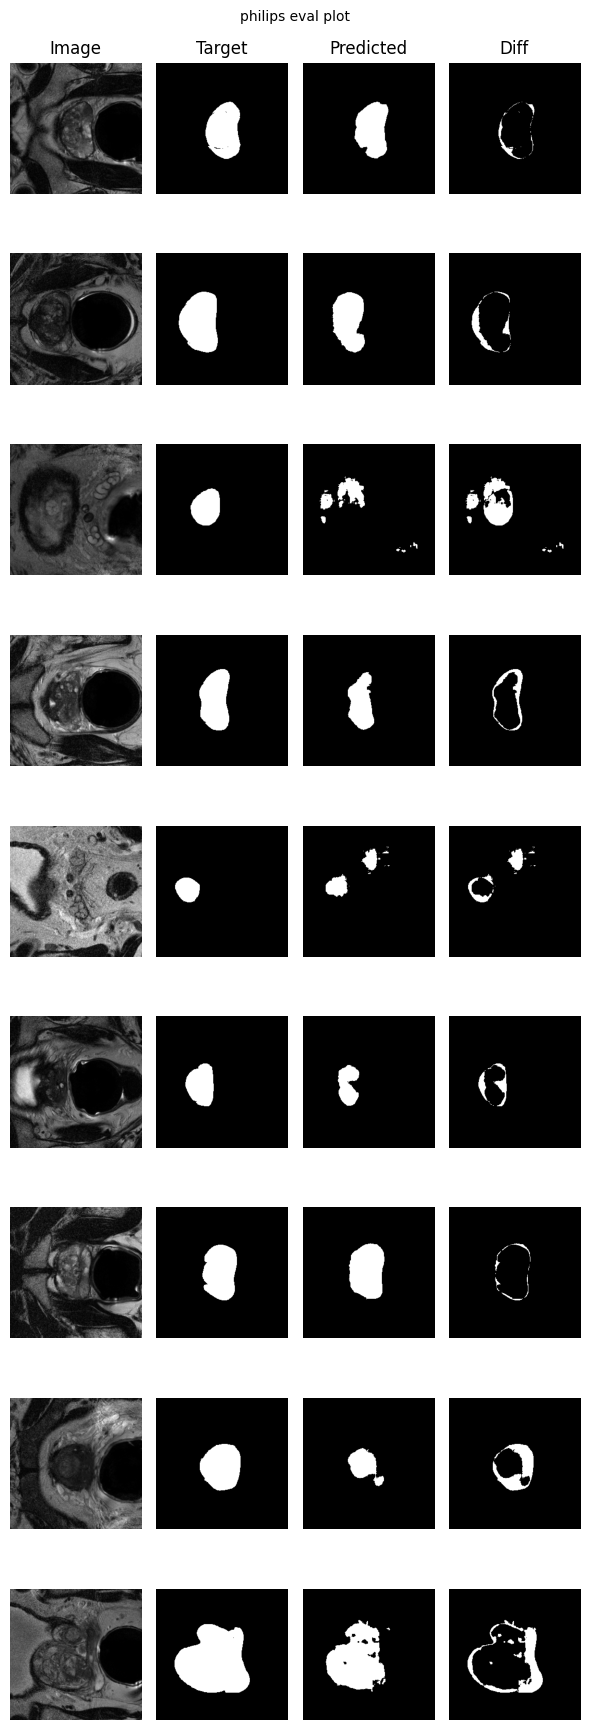

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


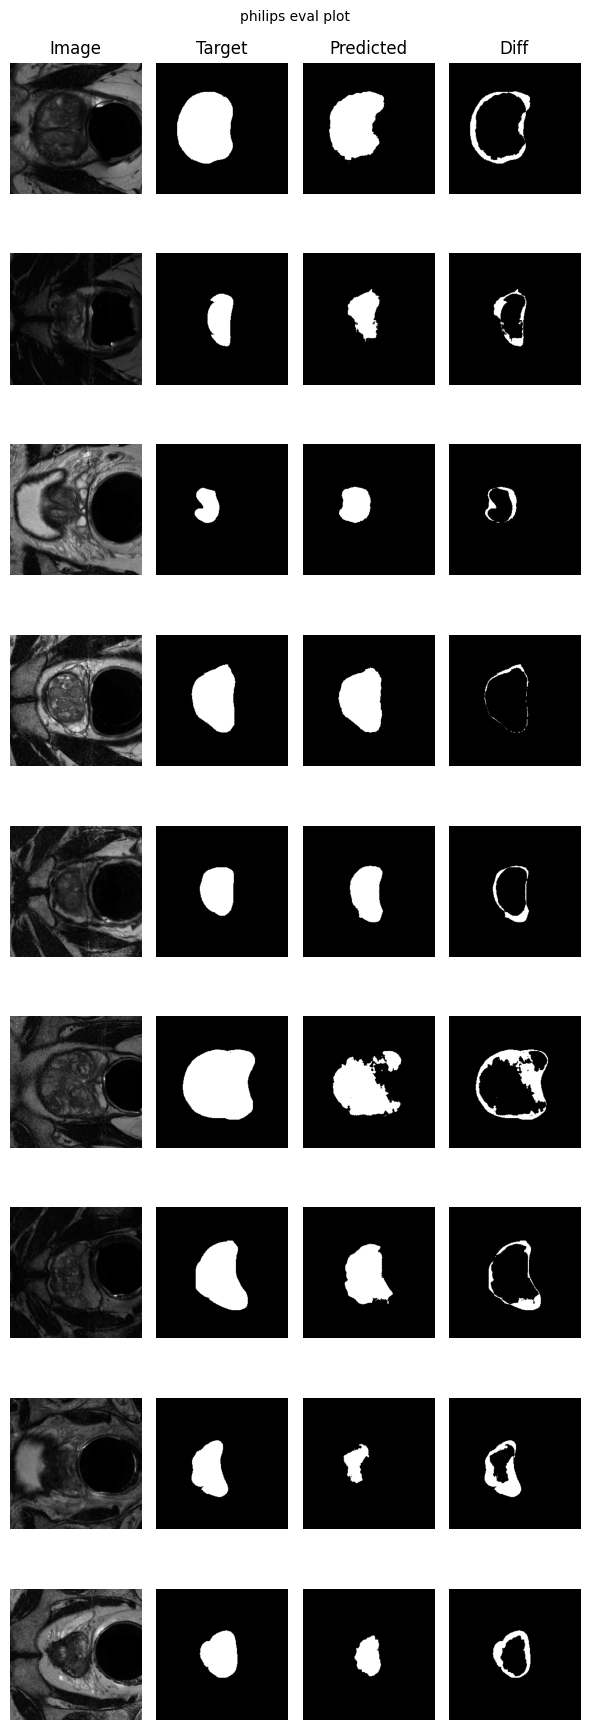

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


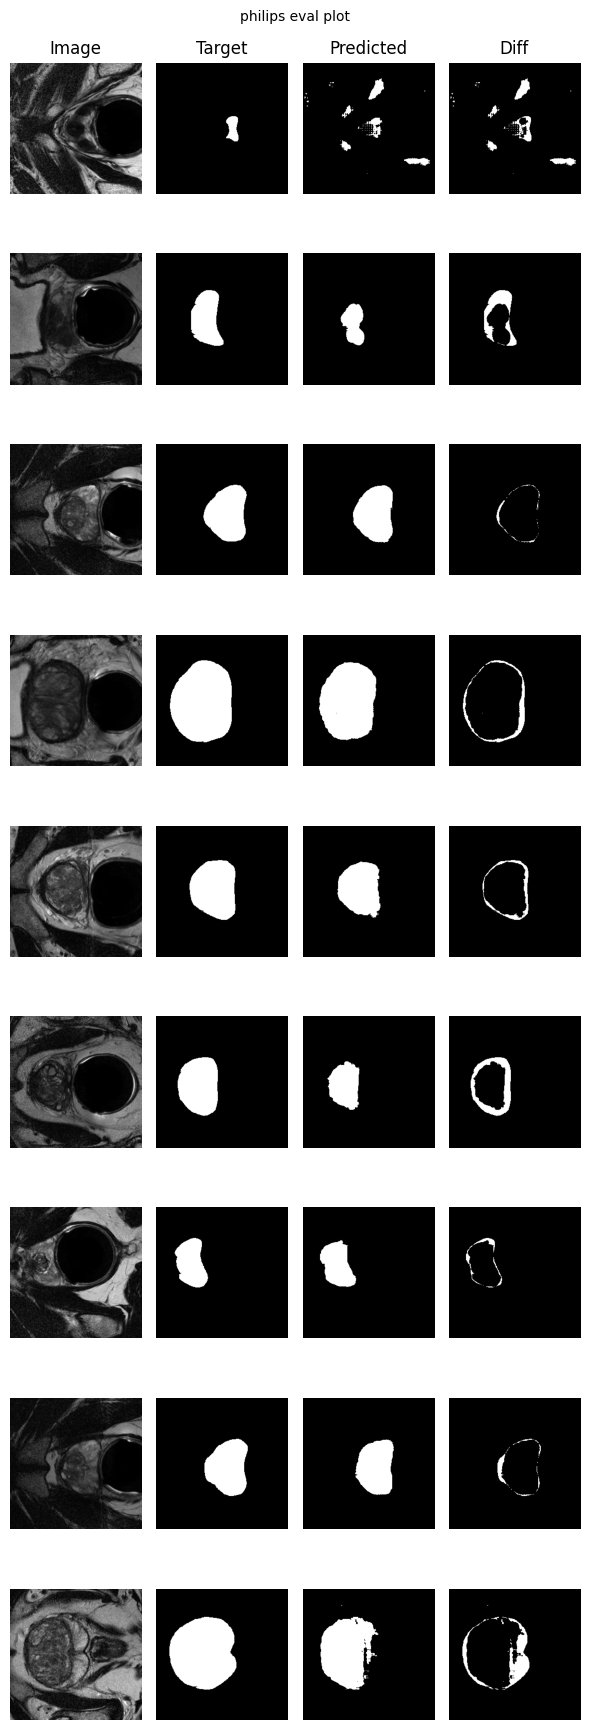

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


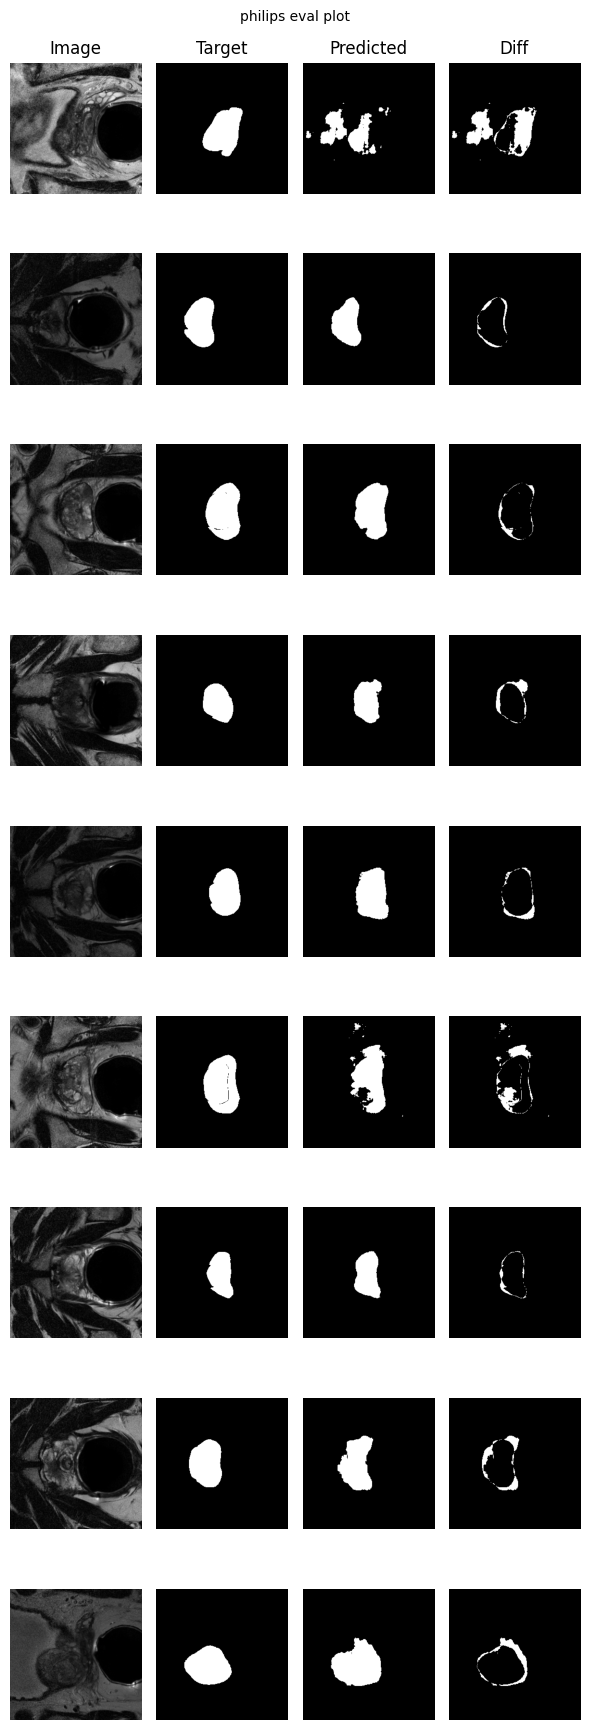

Loading evaluation PMRI dataset for vendor ge ...
Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


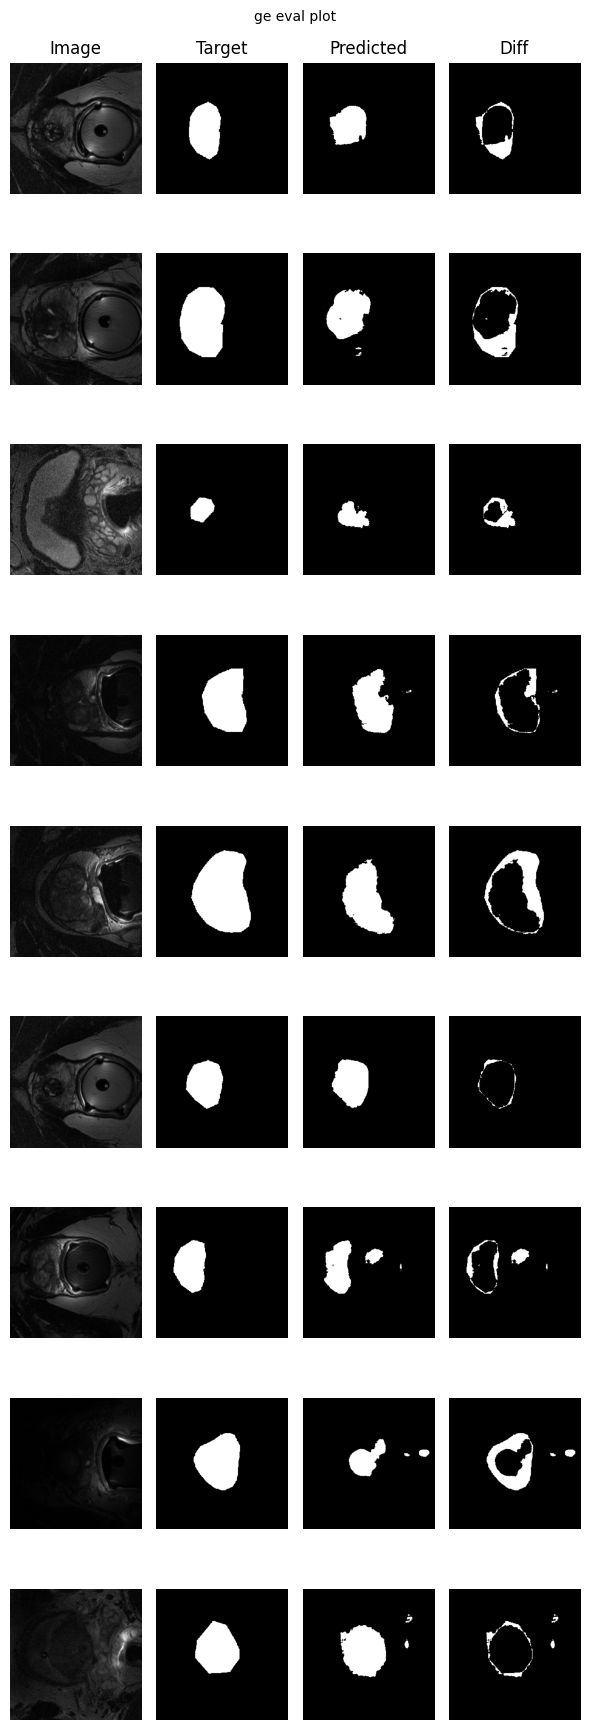

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


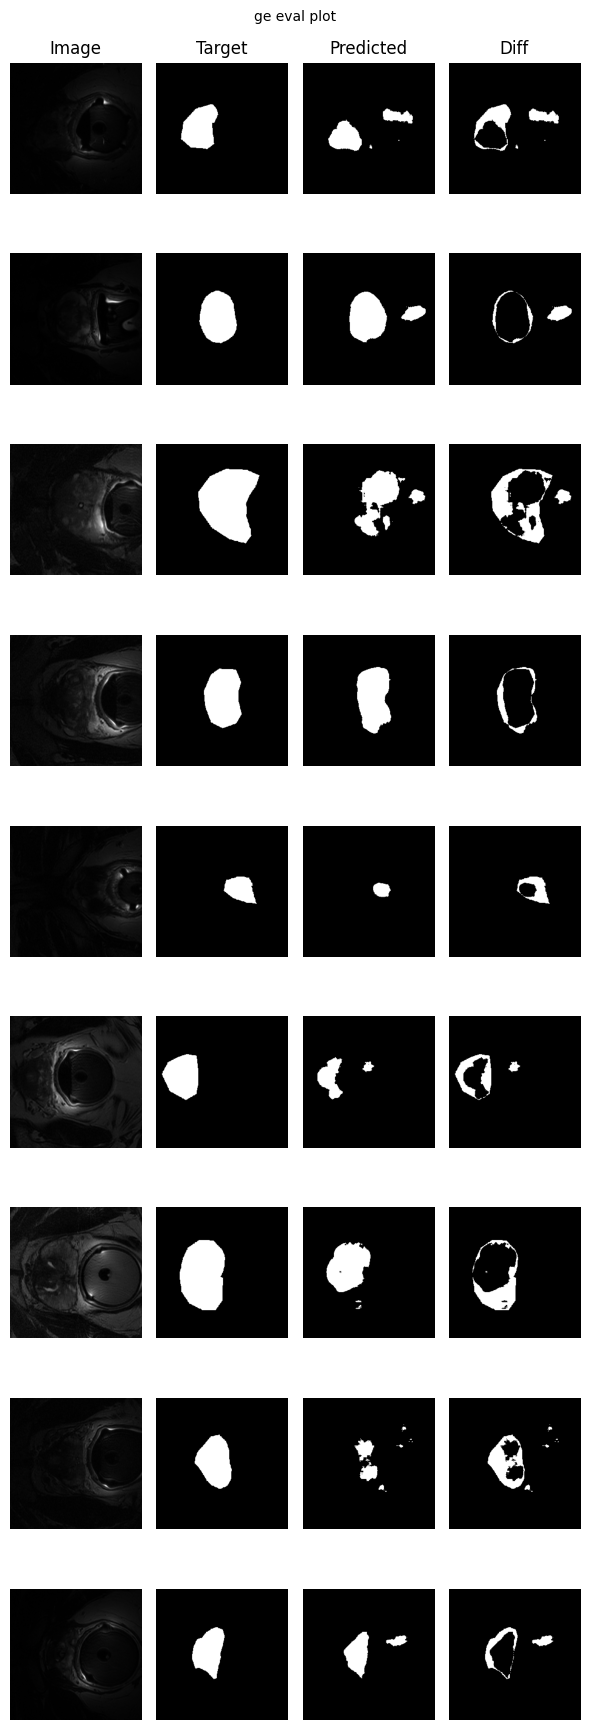

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


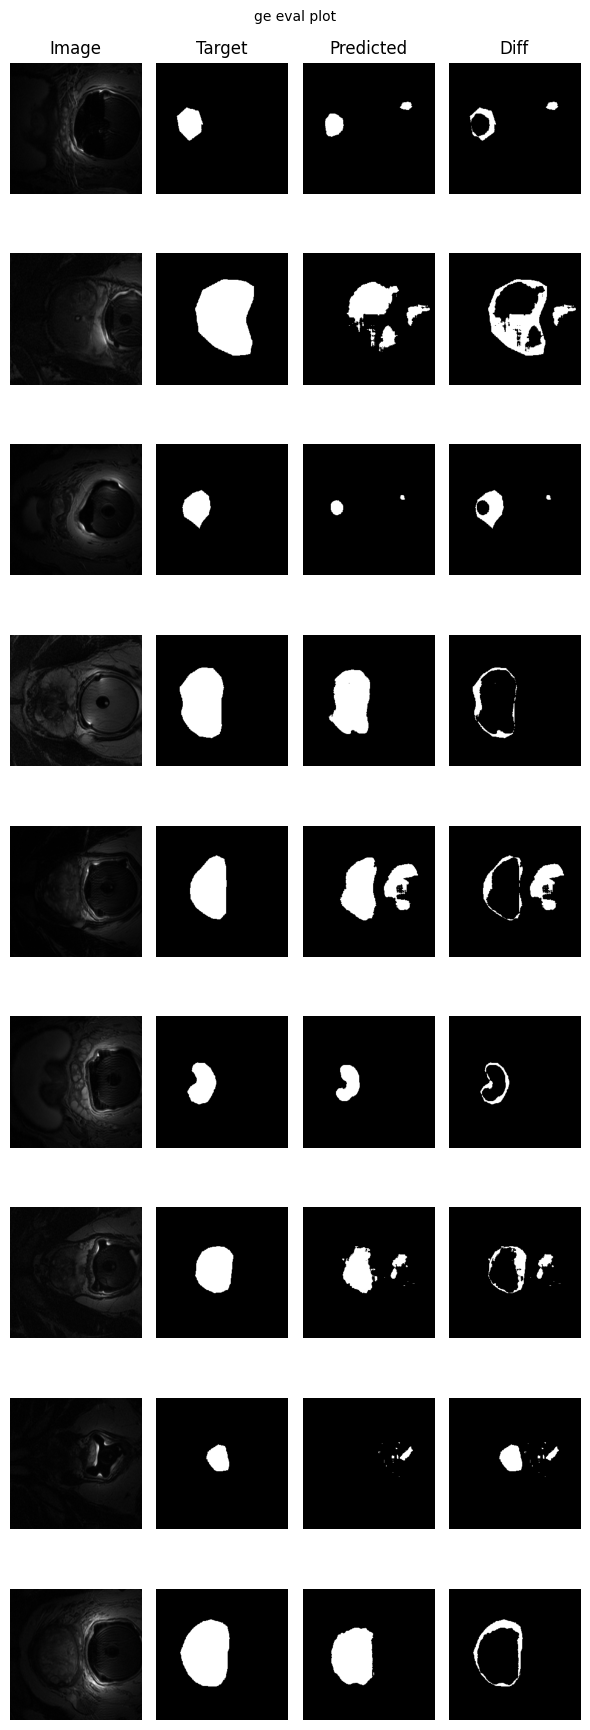

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


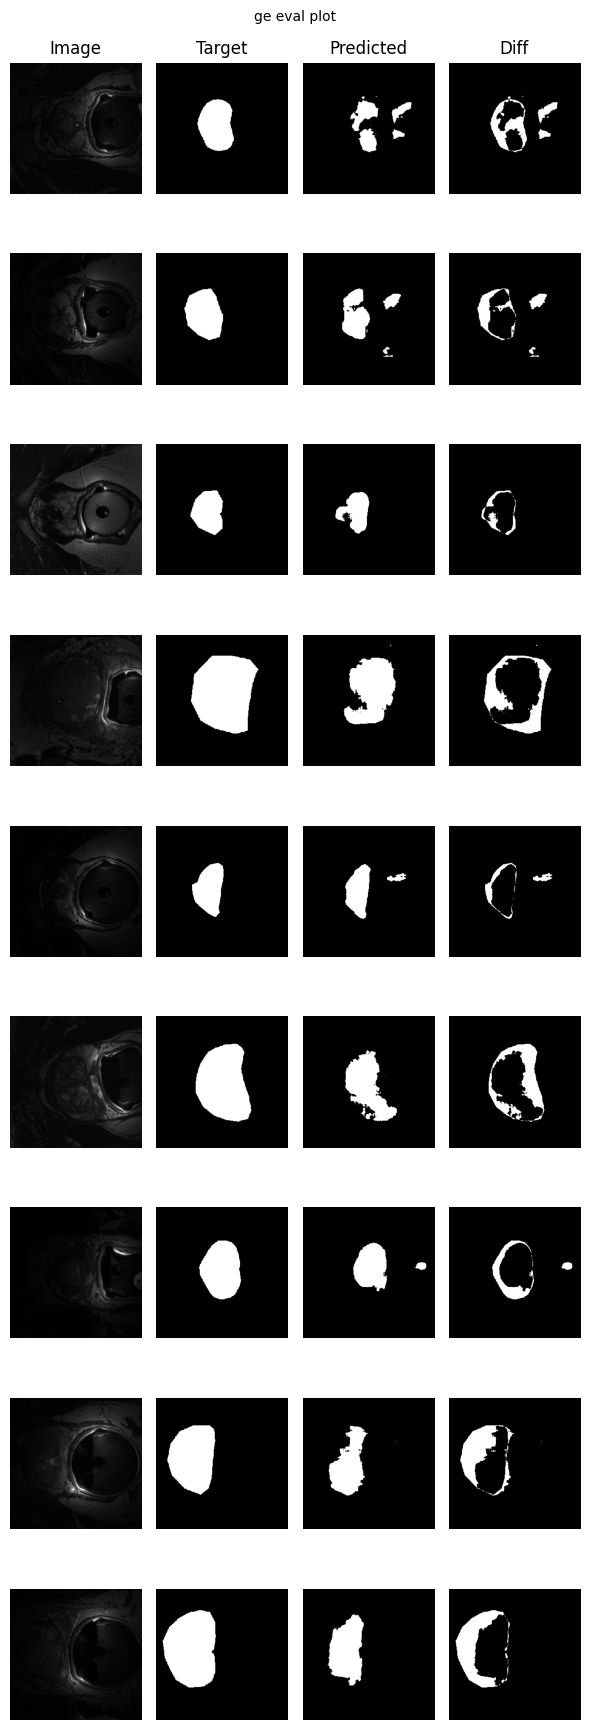

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


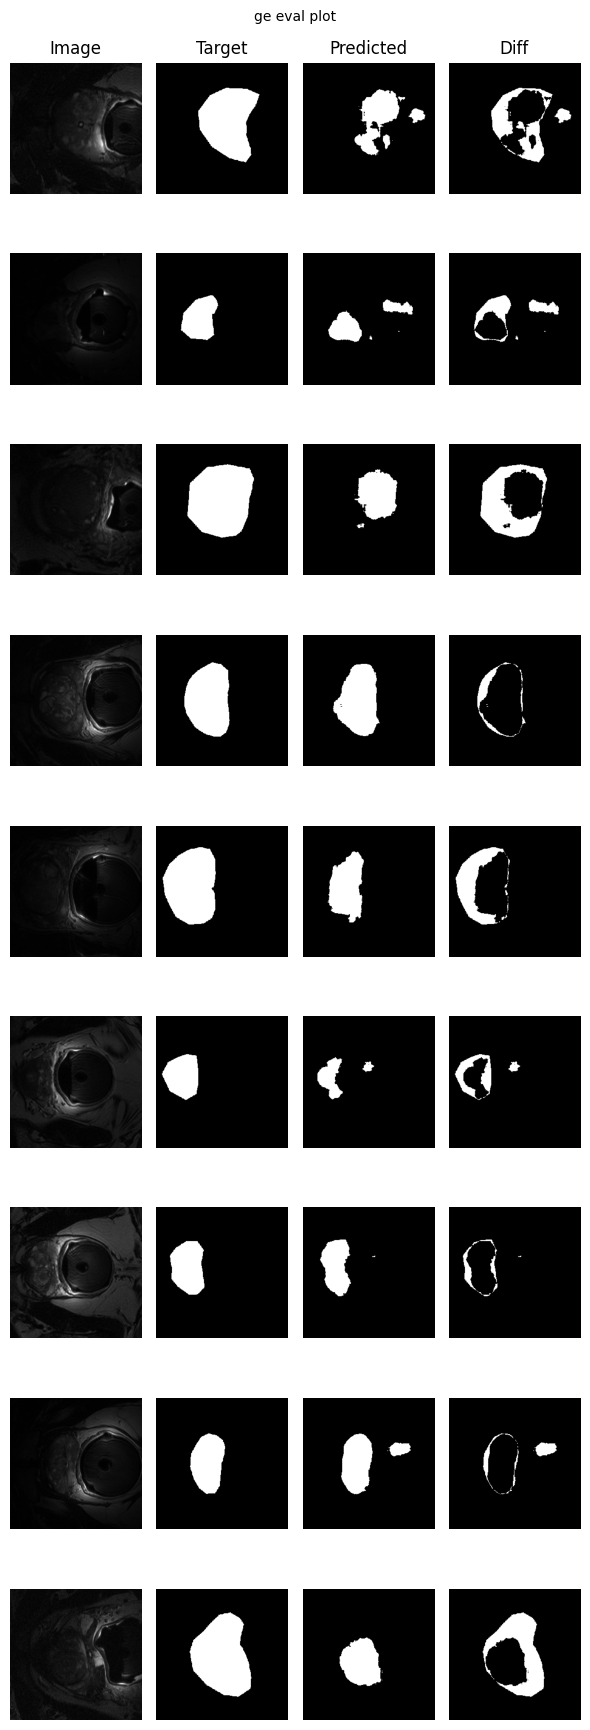

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


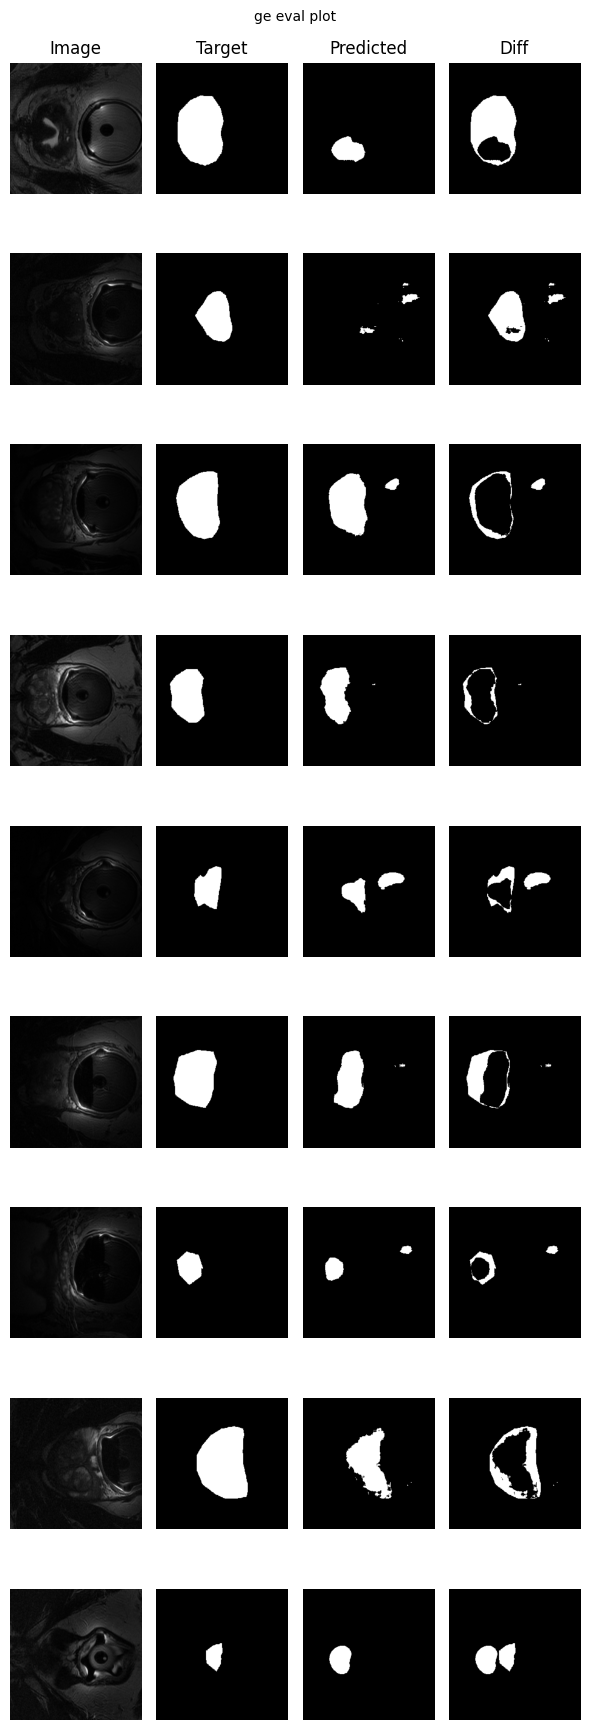

In [5]:
test_vendors = ['siemens', 'philips', 'ge']
for vendor in test_vendors:
    cfg.unet[DATA_KEY].training.subset = 'validation' if vendor in train_vendors else False 
    cfg.unet[DATA_KEY].training.vendor = vendor
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    for n_dims in N_DIMS:
        adapters = [PCA_Adapter(swivel, n_dims, cfg.unet[DATA_KEY].training.batch_size,
                                pre_fit=True, train_gaussian=False, compute_dist=True,
                                name=cfg.wandb.project) for swivel in layer_names]
        adapters = nn.ModuleList(adapters)
        unet, state_dict = get_unet(cfg, update_cfg_with_swivels=False, return_state_dict=True)
        unet_adapted = PCAModuleWrapper(model=unet, adapters=adapters)
        unet_adapted.hook_adapters()
        unet_adapted.to(device);
        metrics[n_dims] = metrics.get(n_dims, {})
        distribution_results[n_dims] = distribution_results.get(n_dims, {})
        for key in data.keys():
            # print(f'{key} dataset length of vendor {vendor}: {len(data[key])}')
            metrics[n_dims][f'{vendor}_eval'] = eval_set(
                cfg=cfg,
                model=unet_adapted,
                dataset=data[key]
            )

        for adapter in unet_adapted.adapters:
            adapter.reduce_dims = False
            adapter.train_gaussian = False
            adapter.compute_dist = False


        for adapter in unet_adapted.adapters:
            th_val = cut_values[n_dims][f'mahal_th_{MAHAL_DIST_PERCENTILE_CUT}_{adapter.swivel}']
            tmp_dists = torch.cat(adapter.distances, dim=0).detach().cpu()
            metrics[n_dims][f'{vendor}_eval'][f'mahal_mean_{adapter.swivel}'] = tmp_dists.mean().item()
            ood = int(torch.sum(tmp_dists > th_val).item())
            iid = int(torch.sum(tmp_dists <= th_val).item())
            metrics[n_dims][f'{vendor}_eval'][f'{adapter.swivel}_ood'] = ood
            metrics[n_dims][f'{vendor}_eval'][f'{adapter.swivel}_iid'] = iid 
            metrics[n_dims][f'{vendor}_eval'][f'{adapter.swivel}_pct_iid'] = iid / (iid + ood)
            metrics[n_dims][f'{vendor}_eval'][f'{adapter.swivel}_pct_ood'] = ood / (iid + ood)
            if adapter.swivel == layer_names[1]:
                iid_dice, ood_dice = eval_pmri_subdice(unet_adapted, data['eval'], tmp_dists, th_val)
                metrics[n_dims][f'{vendor}_eval'][f'{adapter.swivel}_dice_iid'] = iid_dice
                metrics[n_dims][f'{vendor}_eval'][f'{adapter.swivel}_dice_ood'] = ood_dice

    if PLOT: plot_batch(data[key], unet_adapted, title=f'{vendor} eval plot')

In [ ]:
selected_dim = N_DIMS[0]
print(f'Data IPCA with number of features set to {selected_dim}')
df = get_df_from_dict(cfg, metrics[selected_dim])
df

Data IPCA with number of features set to 2


Domain                                           variable     value
0   siemens_train                                         Dice Score  0.961035
1    siemens_eval                                         Dice Score  0.901028
2    philips_eval                                         Dice Score  0.791504
3         ge_eval                                         Dice Score  0.662484
4   siemens_train                            mahal_mean_model.0.conv  1.198669
..            ...                                                ...       ...
87        ge_eval  model.1.submodule.1.submodule.1.submodule.0.co...  0.325670
88  siemens_train  model.1.submodule.1.submodule.1.submodule.0.co...  0.100406
89   siemens_eval  model.1.submodule.1.submodule.1.submodule.0.co...  0.173729
90   philips_eval  model.1.submodule.1.submodule.1.submodule.0.co...  0.783854
91        ge_eval  model.1.submodule.1.submodule.1.submodule.0.co...  0.674330

[92 rows x 3 columns]

In [ ]:
# siemens_eval -> 1, 2, 3, 0
# philips_eval -> 3, 1, 2, 0
# ge_eval      -> 1, 2, 3, 0
# 0 = model.0.conv
# 1 = model.1.submodule.0.conv
# 2 = model.1.submodule.1.submodule.0.conv
# 3 = model.1.submodule.1.submodule.1.submodule.0.conv

In [ ]:
df[df.Domain == 'philips_eval'] 

Domain                                           variable  \
2   philips_eval                                         Dice Score   
6   philips_eval                            mahal_mean_model.0.conv   
10  philips_eval                                   model.0.conv_ood   
14  philips_eval                                   model.0.conv_iid   
18  philips_eval                               model.0.conv_pct_iid   
22  philips_eval                               model.0.conv_pct_ood   
26  philips_eval                mahal_mean_model.1.submodule.0.conv   
30  philips_eval                       model.1.submodule.0.conv_ood   
34  philips_eval                       model.1.submodule.0.conv_iid   
38  philips_eval                   model.1.submodule.0.conv_pct_iid   
42  philips_eval                   model.1.submodule.0.conv_pct_ood   
46  philips_eval                  model.1.submodule.0.conv_dice_iid   
50  philips_eval                  model.1.submodule.0.conv_dice_ood   
54  philips_eval    mahal_mean_model.1.submodule.1.submodule.0.conv   
58  philips_eval           model.1.submodule.1.submodule.0.conv_ood   
62  philips_eval           model.1.submodule.1.submodule.0.conv_iid   
66  philips_eval       model.1.submodule.1.submodule.0.conv_pct_iid   
70  philips_eval       model.1.submodule.1.submodule.0.conv_pct_ood   
74  philips_eval  mahal_mean_model.1.submodule.1.submodule.1.sub...   
78  philips_eval  model.1.submodule.1.submodule.1.submodule.0.co...   
82  philips_eval  model.1.submodule.1.submodule.1.submodule.0.co...   
86  philips_eval  model.1.submodule.1.submodule.1.submodule.0.co...   
90  philips_eval  model.1.submodule.1.submodule.1.submodule.0.co...   

         value  
2     0.791504  
6     4.185957  
10  317.000000  
14   67.000000  
18    0.174479  
22    0.825521  
26    3.440681  
30  305.000000  
34   79.000000  
38    0.205729  
42    0.794271  
46    0.845994  
50    0.777390  
54    3.673417  
58  308.000000  
62   76.000000  
66    0.197917  
70    0.802083  
74    3.777482  
78  301.000000  
82   83.000000  
86    0.216146  
90    0.783854

In [ ]:
# ds_test = Subset(data['eval'], [10,12,14,16,18])
# dataloader = DataLoader(ds_test, batch_size=cfg.unet.prostate.training.batch_size, shuffle=False, drop_last=False)

In [ ]:
# for b in dataloader:
#     print(b['input'].shape)
#     print(b['target'].shape)

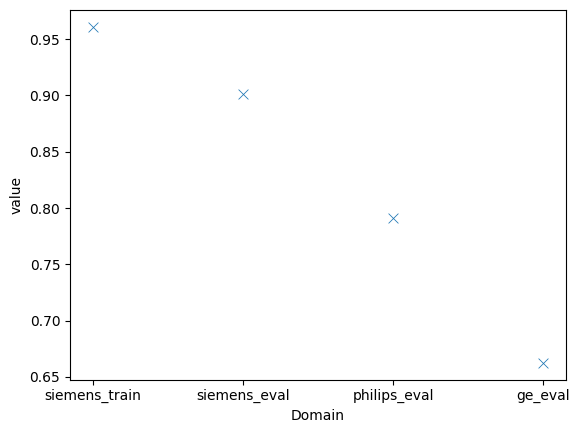

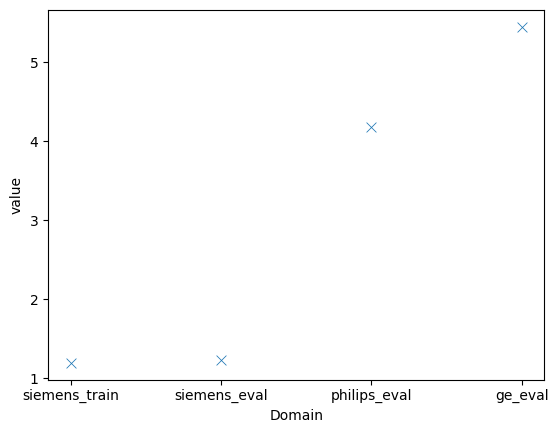

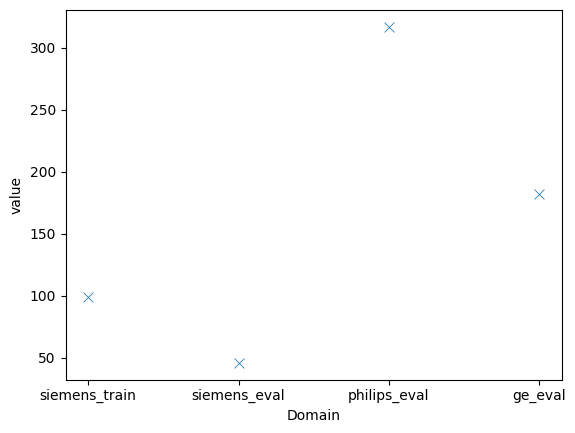

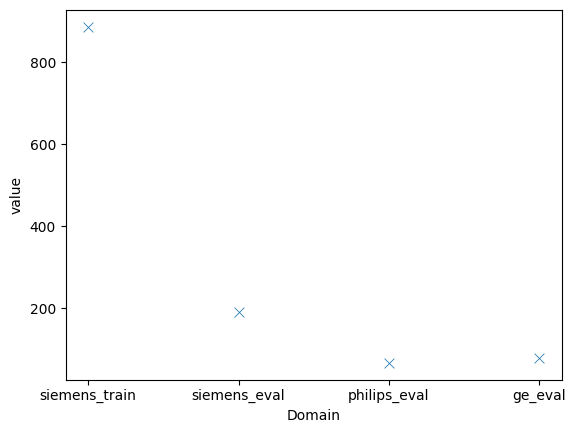

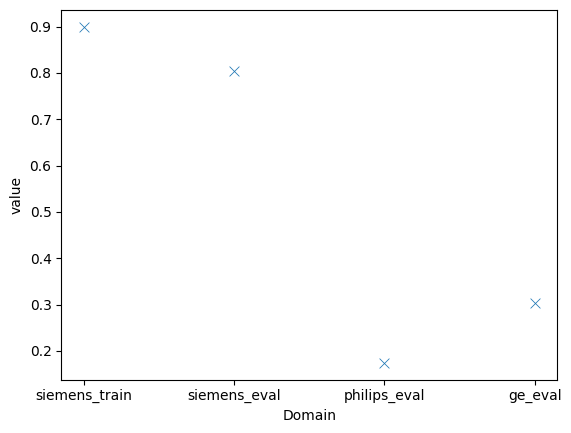

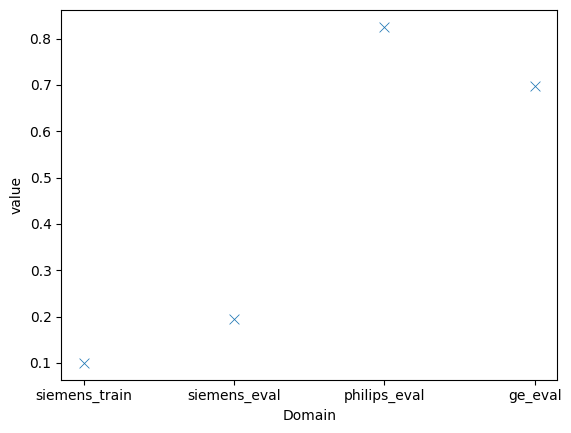

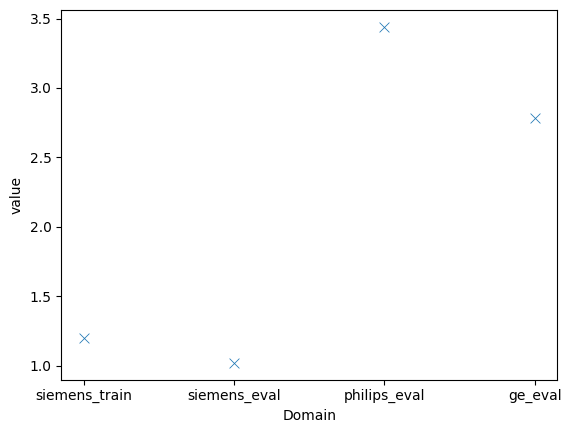

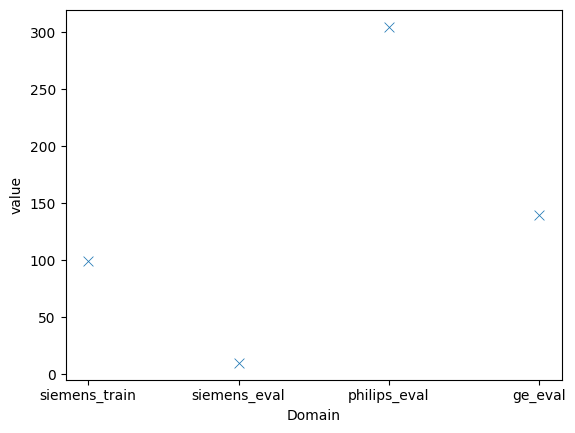

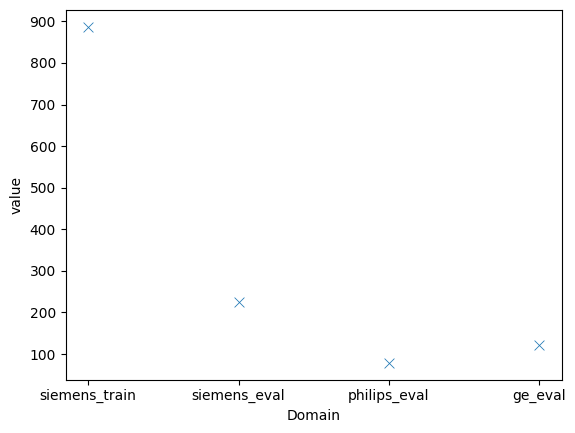

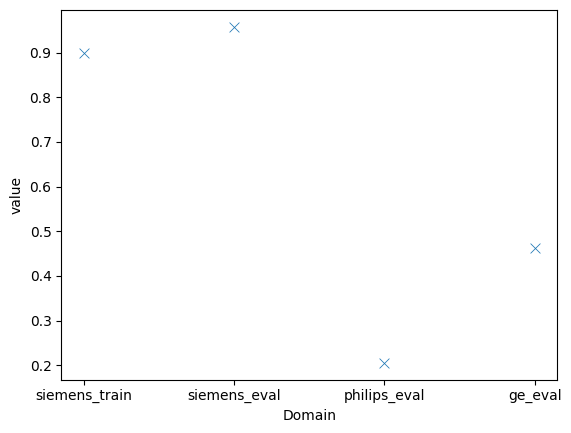

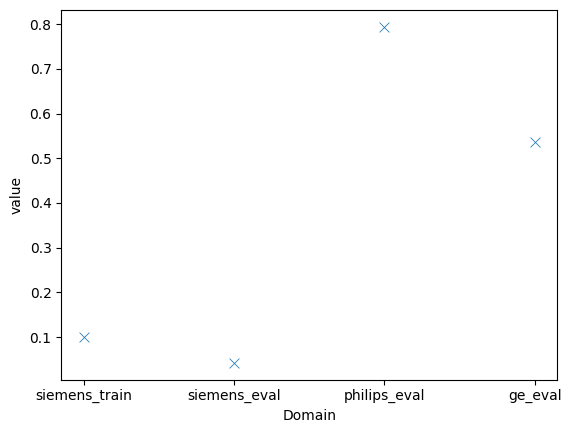

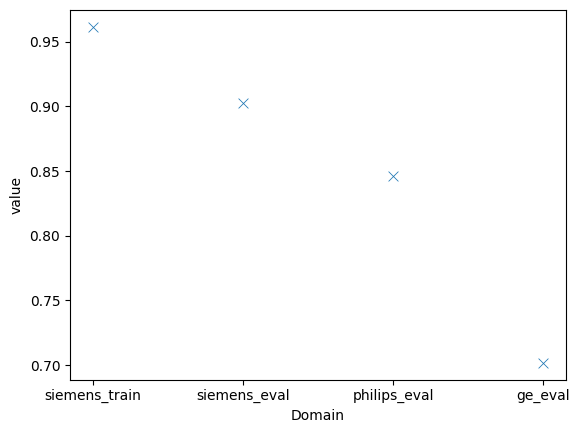

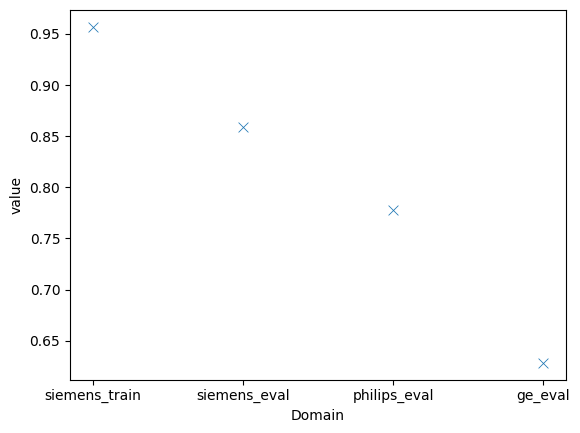

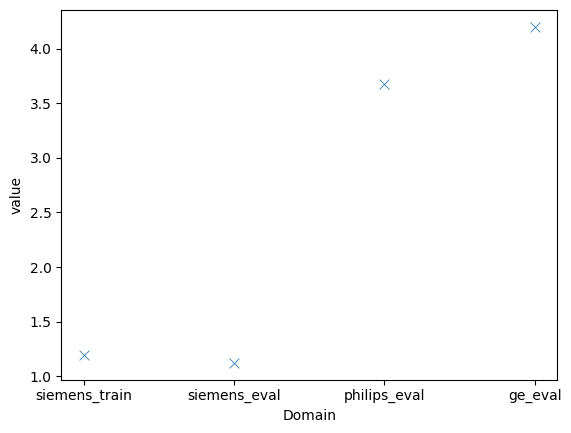

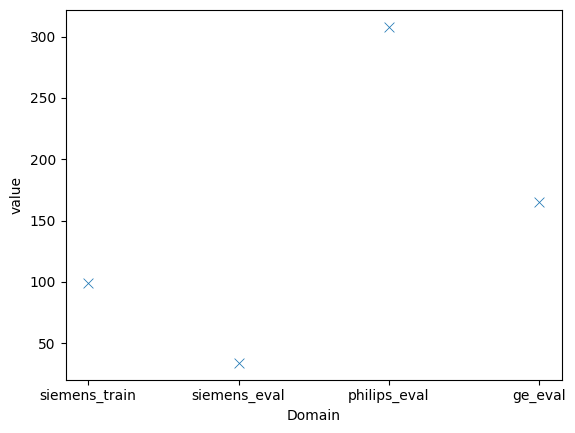

In [ ]:
for i in range(len(df) // 6):
    plt.figure()
    sns.scatterplot(
        data = df[i*4:4*(i+1)],
        x = 'Domain',
        y = 'value',
        #hue = 'Model',
        marker = 'x',
        s = 50
    )

    plt.show()

In [ ]:
# from torchviz import make_dot

In [ ]:
# unet.train()
# X = torch.rand(1, 1, 256, 256).cuda()
# Y = unet(X)
# graph = make_dot(Y.mean(), params=dict(unet.named_parameters()), show_attrs=True, show_saved=True)
# graph.render("model_graph", format="png", directory="./", view=False)